In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

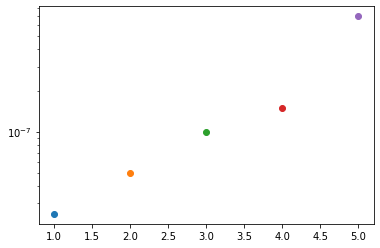

In [3]:
plt.scatter(1, 2.5e-8)
plt.scatter(2, 5e-8)
plt.scatter(3, 1e-7)
plt.scatter(4, 1.5e-7)
plt.scatter(5, 7e-7)
plt.yscale('log')

In [4]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [5]:
# define constants and other parameters
K = 6e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [6]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [7]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [8]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

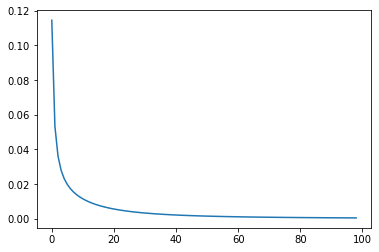

In [9]:
plt.plot(S)

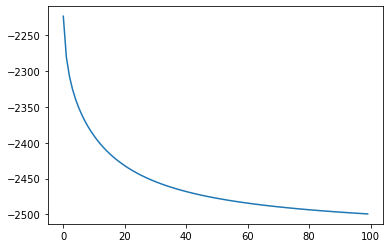

In [10]:
plt.plot(eta)

In [11]:
S[-1]

0.0005155558852047761

In [12]:
eta

array([-2223.33475401, -2280.53967474, -2307.25365159, -2325.30200862,
       -2339.27800089, -2350.82763267, -2360.72520846, -2369.40102475,
       -2377.12273582, -2384.07082975, -2390.37453504, -2396.13069403,
       -2401.41448567, -2406.28591147, -2410.79392734, -2414.97919286,
       -2418.87596991, -2422.51347634, -2425.91687828, -2429.10803517,
       -2432.10607115, -2434.92782124, -2437.58818557, -2440.10041448,
       -2442.47634096, -2444.72657221, -2446.860649  , -2448.8871795 ,
       -2450.81395246, -2452.6480336 , -2454.39584821, -2456.06325234,
       -2457.65559443, -2459.17776899, -2460.63426342, -2462.02919913,
       -2463.36636769, -2464.64926279, -2465.88110849, -2467.06488433,
       -2468.20334773, -2469.29905393, -2470.35437381, -2471.37150996,
       -2472.35251103, -2473.29928466, -2474.21360919, -2475.09714419,
       -2475.95144001, -2476.77794643, -2477.5780205 , -2478.35293372,
       -2479.10387849, -2479.83197406, -2480.53827197, -2481.22376094,
      

In [13]:
eta_adj = eta - eta[-1]

In [14]:
eta_adj

array([2.76065246e+02, 2.18860326e+02, 1.92146349e+02, 1.74097992e+02,
       1.60121999e+02, 1.48572368e+02, 1.38674792e+02, 1.29998976e+02,
       1.22277264e+02, 1.15329171e+02, 1.09025465e+02, 1.03269306e+02,
       9.79855146e+01, 9.31140888e+01, 8.86060729e+01, 8.44208074e+01,
       8.05240304e+01, 7.68865239e+01, 7.34831220e+01, 7.02919651e+01,
       6.72939291e+01, 6.44721790e+01, 6.18118147e+01, 5.92995858e+01,
       5.69236593e+01, 5.46734281e+01, 5.25393513e+01, 5.05128208e+01,
       4.85860478e+01, 4.67519667e+01, 4.50041521e+01, 4.33367479e+01,
       4.17444059e+01, 4.02222313e+01, 3.87657369e+01, 3.73708012e+01,
       3.60336326e+01, 3.47507375e+01, 3.35188918e+01, 3.23351160e+01,
       3.11966525e+01, 3.01009464e+01, 2.90456265e+01, 2.80284903e+01,
       2.70474893e+01, 2.61007156e+01, 2.51863911e+01, 2.43028561e+01,
       2.34485603e+01, 2.26220539e+01, 2.18219798e+01, 2.10470666e+01,
       2.02961218e+01, 1.95680262e+01, 1.88617283e+01, 1.81762393e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_4.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_4.csv', alpha, delimiter = ',')